In [1]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=b5f645ff55db1be8822134f519e6d8e242cb117b12d9dce82c3c52c9626993c6
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
import numpy as np
import torch
from seqeval.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tag occurences (use this as reference when setting class_weight_beta parameter and ignored_tags list):

[('B-area', 4310), ('B-bookday', 3208), ('B-bookpeople', 3180), ('B-bookstay', 2306), ('B-booktime', 1561), ('B-food', 3804), ('B-name', 1787), ('B-pricerange', 4300), ('B-stars', 1841), ('B-type', 2150), ('I-area', 812), ('I-bookday', 1039), ('I-bookpeople', 226), ('I-bookstay', 2), ('I-booktime', 3120), ('I-food', 2994), ('I-name', 4212), ('I-pricerange', 564), ('I-stars', 1), ('I-type', 1049), ('O', 299338)]

P.S. yes, the dataset really is that bad

These are the models that can be used for token classification: https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification (note, this might send you to the wrong location in the page, just CTRL+F "AutoModelForTokenClassification")

In [3]:
TRANSFORMER_MODEL_NAME = 'brad1141/gpt2-finetuned-comp2'
SAVE_MODEL_SUFFIX = 'with_intent'
save_model_name = TRANSFORMER_MODEL_NAME.split('/')[-1]
epochs = 5
batch_size = 4
learning_rate = 2e-5
class_weight_beta = 0.999 # 0.99999 (yes, 5 nines) should work ok, increase number of nines if you want stronger imbalance compensation
patience = 2
ignored_tags = ['I-hotel-bookstay', 'I-hotel-stars']
use_history = True

In [4]:
# Random tests to show how the tokenizer/tokenized function work
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)
inputs = tokenizer("We love doing NLI!", padding = 'max_length', return_tensors="pt")
print(tokenizer.decode(inputs.input_ids[0]))
print(inputs.token_to_word(0))
span = inputs.token_to_chars(1)
span[1]
# print(inputs.char_to_token(6))
# inputs

 We love doing NLI!<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo

7

In [5]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

In [6]:
def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_token_bio_tags(dataset):
    tokens_list = []
    bio_tags_list = []
    useful_pos_list = []
    
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):

            if speaker != 0:
                continue
            # Skip using dialogue act intents
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
            #     continue
            # Skip using frame services
            if 'other' in process_service_list(frames['service']):
                continue
            
            if j == 0:
                prev_user_utterance = ''
                prev_user_acts = []
                prev_bot_utterance = ''
                prev_bot_acts = []
            else:
                prev_user_utterance = turns['utterance'][j - 2]
                prev_user_acts = process_intent_list(turns['dialogue_acts'][j - 2]['dialog_act']['act_type'])
                prev_bot_utterance = turns['utterance'][j - 1]
                prev_bot_acts = process_intent_list(turns['dialogue_acts'][j - 1]['dialog_act']['act_type'])
            
            composed_prefix = ''
            if use_history:
                composed_prefix = ' | '.join([prev_user_utterance, ', '.join(prev_user_acts), prev_bot_utterance, ', '.join(prev_bot_acts)]) + ' | '
                utterance = composed_prefix + utterance
            
            span_info = dialogue_act['span_info']
            act_slot_names = span_info['act_slot_name']
            act_slot_values = span_info['act_slot_value']
            span_starts = span_info['span_start']
            span_ends = span_info['span_end']
            act_types = span_info['act_type']
            slots = {slot_name : {'start': start + len(composed_prefix), 'end': end + len(composed_prefix), 'act_type': act_type} for slot_name, start, end, act_type in zip(act_slot_names, span_starts, span_ends, act_types)}
            
            tokenized = tokenizer(utterance, padding = 'max_length')
            token_tags = [None] * len(tokenized.input_ids)
            
            for c in range(len(composed_prefix), len(utterance)):
                if tokenized.char_to_token(c) is not None:
                    token_tags[tokenized.char_to_token(c)] = 'O'
            
            # for j in range(len(token_tags)):
            #     if tokenized.token_to_word(j) is not None:
            #         token_tags[j] = 'O'
            
            for slot_name in slots:
                slot_start, slot_end = slots[slot_name]['start'], slots[slot_name]['end']
                act_type = slots[slot_name]['act_type'].split("-")[0].lower() + '-'
                covered_tokens = list(dict.fromkeys(tokenized.char_to_token(k) for k in range(slot_start, slot_end) if utterance[k] != ' '))
                for j, covered_token in enumerate(covered_tokens):
                    bio_type = 'B-' if j == 0 else 'I-'
                    if bio_type + act_type + slot_name not in ignored_tags:
                        token_tags[covered_token] = bio_type + act_type + slot_name
            
            # print([*zip(tokenizer.convert_ids_to_tokens(tokenized.input_ids), token_tags)])

            tokens_list.append(tokenized)
            bio_tags_list.append(np.array(token_tags))
            useful_pos_list.append((tokenized.char_to_token(len(composed_prefix)), tokenized.char_to_token(len(utterance) - 1) + 1))
            
    return tokens_list, bio_tags_list, useful_pos_list

In [7]:
dataset = load_dataset('multi_woz_v22')

train = preprocess_split(dataset, 'train')
val = preprocess_split(dataset, 'validation')
test = preprocess_split(dataset, 'test')

train_tokens, train_bio_tags, train_useful_pos = extract_token_bio_tags(train)
possible_bio_tags = sorted(set(filter(lambda tag : tag is not None, np.concatenate(train_bio_tags))))
print(possible_bio_tags)
tag_to_encoding = {tag : encoding for encoding, tag in enumerate(possible_bio_tags)}
# - 100 is default ignore index for the pytorch cross entropy function
tag_to_encoding[None] = -100
encoding_to_tag = {encoding : tag for encoding, tag in enumerate(possible_bio_tags)}
train_encoded_tags = [[tag_to_encoding[tag] for tag in tags] for tags in train_bio_tags]

val_tokens, val_bio_tags, val_useful_pos = extract_token_bio_tags(val)
val_encoded_tags = [[tag_to_encoding[tag] for tag in tags] for tags in val_bio_tags]

test_tokens, test_bio_tags, test_useful_pos = extract_token_bio_tags(test)
test_encoded_tags = [np.array([tag_to_encoding[tag] for tag in tags]) for tags in test_bio_tags]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Extracting data files:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset multi_woz_v22 downloaded and prepared to /root/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/7452f16a8b502e97df5c04cc4ee5436464762fa93b1ce778dd14181e79d8b51a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 6321/6321 [00:21<00:00, 294.73it/s]


['B-hotel-area', 'B-hotel-bookday', 'B-hotel-bookpeople', 'B-hotel-bookstay', 'B-hotel-name', 'B-hotel-pricerange', 'B-hotel-stars', 'B-hotel-type', 'B-restaurant-area', 'B-restaurant-bookday', 'B-restaurant-bookpeople', 'B-restaurant-booktime', 'B-restaurant-food', 'B-restaurant-name', 'B-restaurant-pricerange', 'I-hotel-area', 'I-hotel-bookday', 'I-hotel-bookpeople', 'I-hotel-name', 'I-hotel-pricerange', 'I-hotel-type', 'I-restaurant-area', 'I-restaurant-bookday', 'I-restaurant-bookpeople', 'I-restaurant-booktime', 'I-restaurant-food', 'I-restaurant-name', 'I-restaurant-pricerange', 'O']


100%|██████████| 745/745 [00:02<00:00, 309.60it/s]


Where the idea of the next cell comes from:

https://towardsdatascience.com/handling-class-imbalanced-data-using-a-loss-specifically-made-for-it-6e58fd65ffab

In [8]:
samples_per_class = [0] * len(possible_bio_tags)
for tags, useful_pos_batch in zip(train_bio_tags, train_useful_pos):
    for tag in tags:
        if tag is not None:
            samples_per_class[tag_to_encoding[tag]] += 1

print("Class counts:")
print([*zip(possible_bio_tags, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(possible_bio_tags)
print("Class weights:")
print([*zip(possible_bio_tags, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('B-hotel-area', 1817), ('B-hotel-bookday', 1827), ('B-hotel-bookpeople', 1795), ('B-hotel-bookstay', 2306), ('B-hotel-name', 882), ('B-hotel-pricerange', 1752), ('B-hotel-stars', 1841), ('B-hotel-type', 2150), ('B-restaurant-area', 2493), ('B-restaurant-bookday', 1381), ('B-restaurant-bookpeople', 1385), ('B-restaurant-booktime', 1561), ('B-restaurant-food', 3804), ('B-restaurant-name', 905), ('B-restaurant-pricerange', 2548), ('I-hotel-area', 427), ('I-hotel-bookday', 605), ('I-hotel-bookpeople', 114), ('I-hotel-name', 2121), ('I-hotel-pricerange', 247), ('I-hotel-type', 1045), ('I-restaurant-area', 378), ('I-restaurant-bookday', 433), ('I-restaurant-bookpeople', 112), ('I-restaurant-booktime', 3120), ('I-restaurant-food', 2965), ('I-restaurant-name', 2068), ('I-restaurant-pricerange', 251), ('O', 299150)]
Class weights:
[('B-hotel-area', 0.5364044224524936), ('B-hotel-bookday', 0.5353713308485699), ('B-hotel-bookpeople', 0.5387284187492944), ('B-hotel-bookstay', 0.498

In [9]:
def batchify_tokens_tags(tokens_list, encoded_tags_list, useful_pos_list, batch_size):
    ids_batch = []
    mask_batch = []
    useful_pos_batch = []
    labels_batch = []
    
    if encoded_tags_list is None:
        encoded_tags_list = range(len(tokens_list))
    
    if useful_pos_list is None:
        useful_pos_list = range(len(tokens_list))
    
    for tokens, encoded_tags, useful_pos in zip(tokens_list, encoded_tags_list, useful_pos_list):
        ids_batch.append(tokens.input_ids)
        mask_batch.append(tokens.attention_mask)
        useful_pos_batch.append(useful_pos)
        labels_batch.append(encoded_tags)
        
        if len(ids_batch) == batch_size:
            yield torch.Tensor(ids_batch).long().cuda(), torch.Tensor(mask_batch).cuda(), useful_pos_batch, torch.Tensor(labels_batch).long().cuda()
            ids_batch.clear()
            mask_batch.clear()
            useful_pos_batch.clear()
            labels_batch.clear()
    
    yield torch.Tensor(ids_batch).long().cuda(), torch.Tensor(mask_batch).cuda(), useful_pos_batch, torch.Tensor(labels_batch).long().cuda()
    return None

def outputs_keep_useful_part(logits_batch, labels_batch, useful_pos_batch):
    logits_useful = torch.zeros(logits_batch.shape).cuda()
    labels_useful = torch.zeros(labels_batch.shape).cuda().long()
    for i, useful_pos in enumerate(useful_pos_batch):
        logits_useful[i, useful_pos[0] - 1 : useful_pos[1] + 1, :] = logits_batch[i, useful_pos[0] - 1 : useful_pos[1] + 1, :]
        labels_useful[i, useful_pos[0] - 1 : useful_pos[1] + 1] = labels_batch[i, useful_pos[0] - 1 : useful_pos[1] + 1]
    return logits_useful, labels_useful

In [10]:
def compute_loss(transformer, tokens, encoded_tags, useful_pos_list, batch_size):
    transformer.eval()
    losses = []
    with torch.no_grad():
        for ids_batch, mask_batch, useful_pos_batch, labels_batch in batchify_tokens_tags(tokens, encoded_tags, useful_pos_list, batch_size):
            out = transformer.forward(input_ids = ids_batch, attention_mask = mask_batch)
            
            # logits_useful, labels_useful = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
            logits_useful = out.logits
            labels_useful = labels_batch
            
            loss = nn.functional.cross_entropy(input = torch.transpose(logits_useful, 1, 2), target = labels_useful, weight = class_weights)
            losses.append(loss.item())
    transformer.train()
    return np.mean(losses)

def predict(transformer, tokens, batch_size):
    transformer.eval()
    predictions = []
    with torch.no_grad():
        for ids_batch, mask_batch, _, _ in batchify_tokens_tags(tokens, None, None, batch_size):
            out = transformer.forward(input_ids = ids_batch, attention_mask = mask_batch)
            res = torch.argmax(out.logits, dim = 2).cpu().detach().numpy()
            predictions.append(res)
    return np.concatenate(predictions)

def useful_flattened_tokens(tokens_list, useful_pos_list):
    return np.concatenate([tokens[useful_pos[0] : useful_pos[1]] for tokens, useful_pos in zip(tokens_list, useful_pos_list)])

In [11]:
transformer = AutoModelForTokenClassification.from_pretrained(TRANSFORMER_MODEL_NAME, num_labels = len(possible_bio_tags), ignore_mismatched_sizes = True).cuda()
transformer.train()
# TODO: maybe use the parameters that the pre-trained model was trained with??
optim = torch.optim.Adam(transformer.parameters(), lr = learning_rate)

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at brad1141/gpt2-finetuned-comp2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([29]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training for 29 classes
Epoch 1: Train loss = 0.18728162800249046, Val loss = 0.09698950005491017
Epoch 2: Train loss = 0.08946368011771001, Val loss = 0.0845161586477115
Epoch 3: Train loss = 0.07267029122193155, Val loss = 0.0819720069788921
Epoch 4: Train loss = 0.06016012213855682, Val loss = 0.08724404617523038
Epoch 5: Train loss = 0.05126490453659806, Val loss = 0.09100327297946087


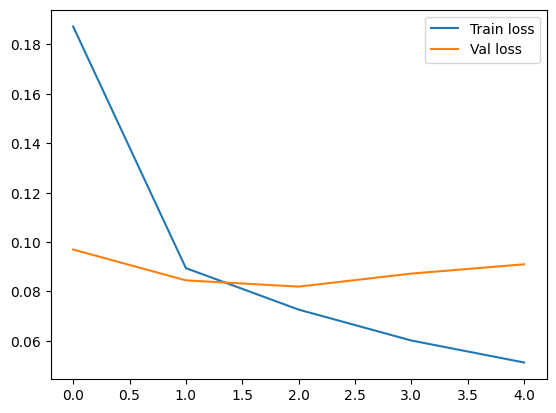

In [12]:
print(f"Training for {len(possible_bio_tags)} classes")

train_losses = []
val_losses = []
min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for ids_batch, mask_batch, useful_pos_batch, labels_batch in batchify_tokens_tags(train_tokens, train_encoded_tags, train_useful_pos, batch_size):
        optim.zero_grad()
        out = transformer.forward(input_ids = ids_batch, attention_mask = mask_batch)
        
        # logits_final, labels_final = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
        logits_final = out.logits
        labels_final = labels_batch
        
        loss = nn.functional.cross_entropy(input = torch.transpose(logits_final, 1, 2), target = labels_final, weight = class_weights)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(transformer, val_tokens, val_encoded_tags, val_useful_pos, batch_size)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        transformer.save_pretrained('saved_models/SF_' + save_model_name + '_' + SAVE_MODEL_SUFFIX)
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

del transformer
del optim

plt.plot(train_losses, label = 'Train loss')
plt.plot(val_losses, label = 'Val loss')
plt.legend()
plt.show()

In [13]:
transformer = AutoModelForTokenClassification.from_pretrained('saved_models/SF_' +  save_model_name + '_' + SAVE_MODEL_SUFFIX, num_labels = len(possible_bio_tags)).cuda()

with torch.no_grad():
    predicted_encoded_tags = predict(transformer, test_tokens, batch_size)
predicted_encoded_tags_flattened = [encoding_to_tag[encoding] for encoding in useful_flattened_tokens(predicted_encoded_tags, test_useful_pos)]
test_encoded_tags_flattened = [encoding_to_tag[encoding] for encoding in useful_flattened_tokens(test_encoded_tags, test_useful_pos)]

acc = accuracy_score(test_encoded_tags_flattened, predicted_encoded_tags_flattened)
report = classification_report([test_encoded_tags_flattened], [predicted_encoded_tags_flattened], digits = 3, zero_division = 0)
print(f"Accuracy: {acc:.3f}")
print(report)

# TODO: find a way to predict the intent a slot fills

Accuracy: 0.974
                       precision    recall  f1-score   support

           hotel-area      0.765     0.805     0.784       174
        hotel-bookday      0.887     0.986     0.934       207
     hotel-bookpeople      0.827     0.648     0.727       199
       hotel-bookstay      0.709     0.969     0.819       259
           hotel-name      0.789     0.876     0.830       137
     hotel-pricerange      0.816     0.839     0.827       217
          hotel-stars      0.960     0.884     0.921       190
           hotel-type      0.543     0.926     0.685       243
      restaurant-area      0.887     0.982     0.932       273
   restaurant-bookday      0.886     0.969     0.925       160
restaurant-bookpeople      0.885     0.955     0.918       177
  restaurant-booktime      0.905     0.948     0.926       210
      restaurant-food      0.894     0.955     0.923       378
      restaurant-name      0.698     0.787     0.740       141
restaurant-pricerange      0.820     0